In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('/Users/ponynie/Developer/Python_Code/IntroDMLabChula/Final_Project/children anemia.csv')
unseen = pd.read_csv('/Users/ponynie/Developer/Python_Code/IntroDMLabChula/Final_Project/unseen.csv')
data.describe(include='all')




,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Current marital status,Currently residing with husband/partner,When child put to breast,Had fever in last two weeks,Hemoglobin level adjusted for altitude (g/dl - 1 decimal),Anemia level.1,"Taking iron pills, sprinkles or syrup"
count,33889,33889,33889,33889,33889.000000,33889.000000,13125.000000,13125,33889,33889,33889,32194,21146,30681,10172.000000,10172,30681
unique,7,2,4,5,NaN,NaN,NaN,4,2,2,6,2,41,3,NaN,4,3
top,25-29,Rural,No education,Poorest,NaN,NaN,NaN,Not anemic,Yes,No,Married,Living with her,Immediately,No,NaN,Moderate,No
freq,9462,22204,15375,8057,NaN,NaN,NaN,5333,23994,33817,31190,29588,9343,23044,NaN,3921,25333
mean,NaN,NaN,NaN,NaN,1.823571,19.570923,114.366781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.271923,NaN,NaN
std,NaN,NaN,NaN,NaN,0.705438,4.313569,15.917405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.563735,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,12.000000,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000,16.000000,105.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,2.000000,19.000000,115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000,22.000000,125.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.000000,NaN,NaN


In [15]:
data.drop('Anemia level.1', axis=1, inplace=True)
data.dropna(subset=['Anemia level', 'Had fever in last two weeks','Taking iron pills, sprinkles or syrup'],inplace=True)

data['Currently residing with husband/partner'] = data['Currently residing with husband/partner'].fillna(data['Currently residing with husband/partner'].mode)
data['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'] = data['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'].fillna(data['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'].mean)

data['Age in 5-year groups'] = data['Age in 5-year groups'].apply(lambda x: sum(map(int,x.split('-')))/2)

data.drop(columns=['When child put to breast', 'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)', 'Current marital status'],inplace=True)

data = data[data['Currently residing with husband/partner'].isin(['Living with her', 'Staying elsewhere'])]
data = data[data['Had fever in last two weeks'].isin(['No', 'Yes'])]
data = data[data['Taking iron pills, sprinkles or syrup'].isin(['No', 'Yes'])]

categorical_columns = ['Type of place of residence', 
                       'Highest educational level', 
                       'Wealth index combined', 
                       'Have mosquito bed net for sleeping (from household questionnaire)', 
                       'Smokes cigarettes', 'Currently residing with husband/partner', 
                       'Had fever in last two weeks', 
                       'Taking iron pills, sprinkles or syrup']
numerical_columns = ['Age in 5-year groups', 
                     'Births in last five years', 
                     'Age of respondent at 1st birth', 
                     'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)']
label_column = 'Anemia level'

data.describe(include='all')

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Currently residing with husband/partner,Had fever in last two weeks,"Taking iron pills, sprinkles or syrup"
count,11196.000000,11196,11196,11196,11196.000000,11196.000000,11196.000000,11196,11196,11196,11196,11196,11196
unique,NaN,2,4,5,NaN,NaN,NaN,4,2,2,2,2,2
top,NaN,Rural,No education,Middle,NaN,NaN,NaN,Not anemic,Yes,No,Living with her,No,No
freq,NaN,6908,4363,2453,NaN,NaN,NaN,4582,7774,11171,10030,8322,9103
mean,30.244909,NaN,NaN,NaN,1.819400,19.953644,114.526974,NaN,NaN,NaN,NaN,NaN,NaN
std,6.802664,NaN,NaN,NaN,0.686293,4.442868,15.861529,NaN,NaN,NaN,NaN,NaN,NaN
min,17.000000,NaN,NaN,NaN,1.000000,12.000000,20.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,27.000000,NaN,NaN,NaN,1.000000,17.000000,105.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,32.000000,NaN,NaN,NaN,2.000000,19.000000,115.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,37.000000,NaN,NaN,NaN,2.000000,22.000000,125.000000,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Anemia level', ylabel='Count'>

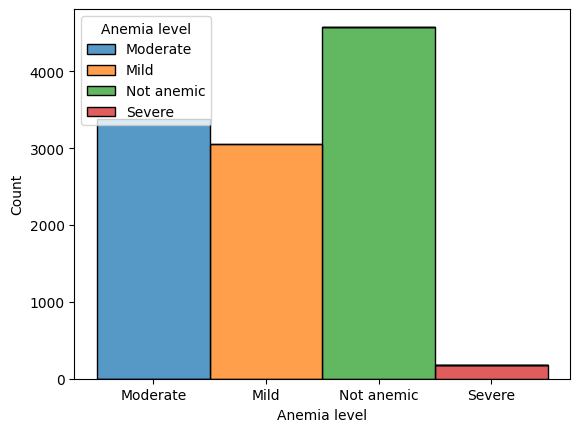

In [16]:
sns.histplot(data=data, x='Anemia level', hue='Anemia level', multiple='stack')

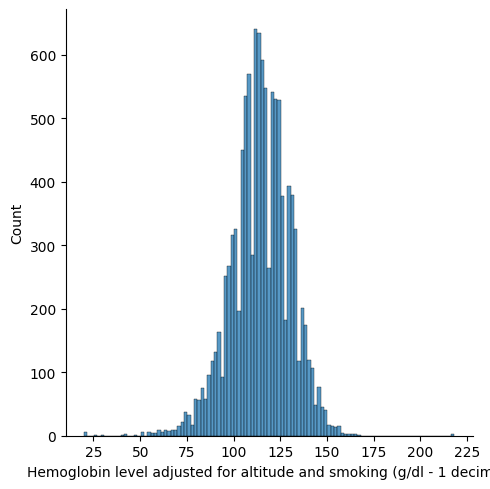

In [17]:
sns.displot(data['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'])

<Axes: >

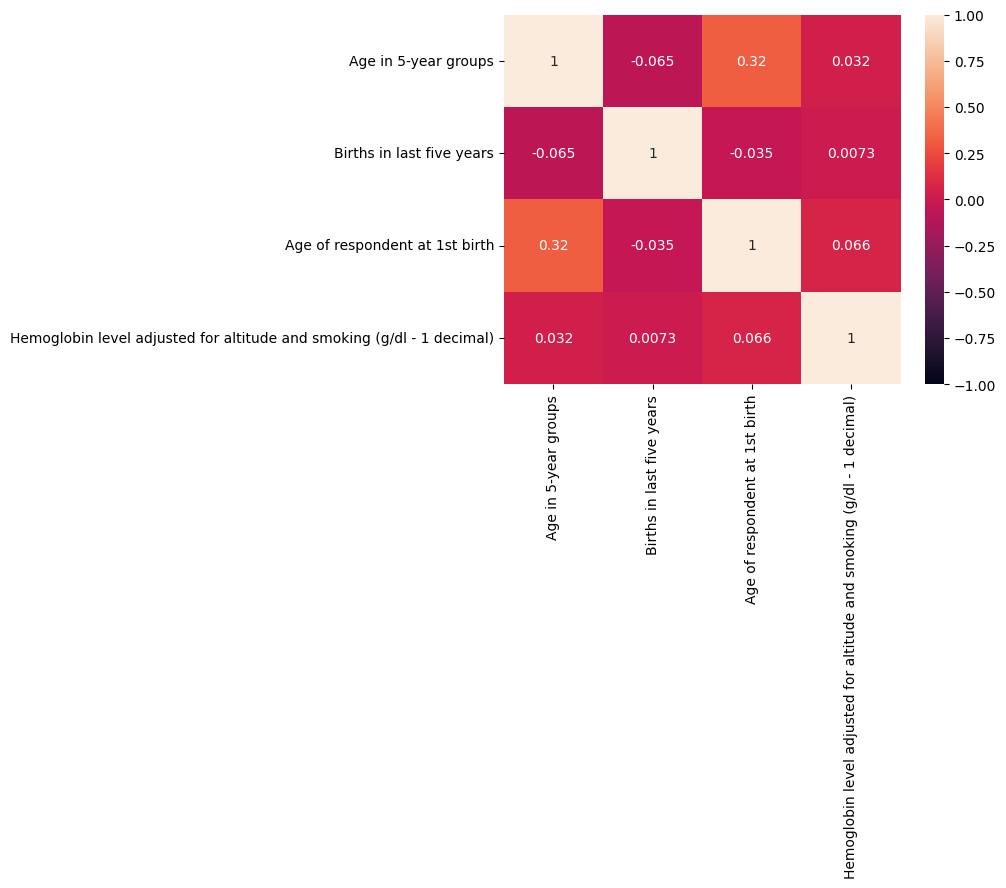

In [18]:
sns.heatmap(data.select_dtypes('number').corr(), annot=True, vmin=-1, vmax=1)

In [19]:
for category in categorical_columns:
    data[category] = data[category].astype('category')
data[label_column] = data[label_column].astype('category')

for categorical in categorical_columns:
    print(data[categorical].cat.categories, categorical)
print(data[label_column].cat.categories, "Label")

Index(['Rural', 'Urban'], dtype='object') Type of place of residence
Index(['Higher', 'No education', 'Primary', 'Secondary'], dtype='object') Highest educational level
Index(['Middle', 'Poorer', 'Poorest', 'Richer', 'Richest'], dtype='object') Wealth index combined
Index(['No', 'Yes'], dtype='object') Have mosquito bed net for sleeping (from household questionnaire)
Index(['No', 'Yes'], dtype='object') Smokes cigarettes
Index(['Living with her', 'Staying elsewhere'], dtype='object') Currently residing with husband/partner
Index(['No', 'Yes'], dtype='object') Had fever in last two weeks
Index(['No', 'Yes'], dtype='object') Taking iron pills, sprinkles or syrup
Index(['Mild', 'Moderate', 'Not anemic', 'Severe'], dtype='object') Label


In [20]:
categorical_np = [data[i].cat.codes.values for i in categorical_columns]
categorical_data = np.stack(categorical_np, 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[1, 3, 4, 1, 0, 0, 0, 0],
        [1, 0, 4, 1, 0, 0, 0, 0],
        [1, 3, 4, 1, 0, 0, 0, 1],
        [1, 3, 4, 1, 0, 0, 0, 1],
        [1, 0, 4, 1, 0, 0, 0, 0],
        [1, 0, 4, 1, 0, 0, 0, 1],
        [1, 0, 4, 1, 0, 0, 0, 0],
        [1, 0, 4, 1, 0, 0, 0, 0],
        [1, 0, 4, 1, 0, 0, 0, 0],
        [1, 3, 4, 1, 0, 0, 0, 1]])

In [21]:
numerical_data = np.stack([data[i].values for i in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:10]

tensor([[ 27.,   1.,  25.,  95.],
        [ 32.,   1.,  30., 113.],
        [ 37.,   2.,  32., 121.],
        [ 22.,   1.,  19., 108.],
        [ 27.,   1.,  24., 116.],
        [ 22.,   2.,  19., 118.],
        [ 22.,   2.,  19., 118.],
        [ 27.,   2.,  22., 134.],
        [ 27.,   2.,  22., 134.],
        [ 27.,   2.,  22.,  95.]])

In [22]:
outputs = torch.tensor(data[label_column].cat.codes.values).flatten()
outputs[:10]

tensor([1, 0, 2, 1, 0, 0, 0, 2, 2, 1], dtype=torch.int8)

In [23]:
categorical_data.shape, numerical_data.shape, outputs.shape

(torch.Size([11196, 8]), torch.Size([11196, 4]), torch.Size([11196]))

In [24]:
total_records = data.shape[0]
test_records = int(total_records * .2) # 20% of the data for testing
train_records = total_records - test_records # 80% of the data for training

categorical_train_data = categorical_data[:train_records]
categorical_test_data = categorical_data[train_records:]
numerical_train_data = numerical_data[:train_records]
numerical_test_data = numerical_data[train_records:]
train_label = outputs[:train_records]
test_label = outputs[train_records:]

print(categorical_train_data.shape, categorical_test_data.shape)
print(numerical_train_data.shape, numerical_test_data.shape)
print(train_label.shape, test_label.shape)

torch.Size([8957, 8]) torch.Size([2239, 8])
torch.Size([8957, 4]) torch.Size([2239, 4])
torch.Size([8957]) torch.Size([2239])


In [25]:
class Model(nn.Module):

    def __init__(self,num_categorical_cols, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x_categorical, x_numerical], 1)
        x = self.layers(x)
        return x #(batch_size, output_size)

In [26]:
hidden_layers = [200,100,50]
class_count = int(data[label_column].cat.codes.nunique())
model = Model(categorical_data.shape[1], numerical_data.shape[1], class_count, hidden_layers, p=0.5)
print(model)

Model(
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [27]:
if torch.backends.mps.is_available():
    print ("MPS device found.")
else:
    print("MPS device not found.")

mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(mps_device)
categorical_train_data = categorical_train_data.to(mps_device)
numerical_train_data = numerical_train_data.to(mps_device)
categorical_test_data = categorical_test_data.to(mps_device)
numerical_test_data = numerical_test_data.to(mps_device)
train_label = train_label.to(mps_device)
test_label = test_label.to(mps_device)  

MPS device found.


In [28]:
class CustomDataset(TensorDataset):
    def __init__(self, x_categorical, x_numerical, y):
        super().__init__(x_categorical, x_numerical, y)
        self.x_categorical = x_categorical
        self.x_numerical = x_numerical
        self.y = y

    def __getitem__(self, index):
        return self.x_categorical[index], self.x_numerical[index], self.y[index]

    def __len__(self):
        return len(self.y)

In [29]:
train_dataset = CustomDataset(categorical_train_data, numerical_train_data, train_label)
train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

Epoch:   1 Batch: 0 Loss: 1.6349003314971924
Epoch:   1 Batch: 4 Loss: 1.3426071405410767
Epoch:   1 Batch: 8 Loss: 1.170608401298523
Epoch:   1 Loss: 1.36895406
Epoch:  26 Batch: 0 Loss: 0.3398425281047821
Epoch:  26 Batch: 4 Loss: 0.378365695476532
Epoch:  26 Batch: 8 Loss: 0.3523639440536499
Epoch:  26 Loss: 0.37198174
Epoch:  51 Batch: 0 Loss: 0.3256971538066864
Epoch:  51 Batch: 4 Loss: 0.32202616333961487
Epoch:  51 Batch: 8 Loss: 0.3140351474285126
Epoch:  51 Loss: 0.33559084
Epoch:  76 Batch: 0 Loss: 0.32677507400512695
Epoch:  76 Batch: 4 Loss: 0.3138181269168854
Epoch:  76 Batch: 8 Loss: 0.326378732919693
Epoch:  76 Loss: 0.31523046
Final Epoch: 100 Loss: 0.3017762303


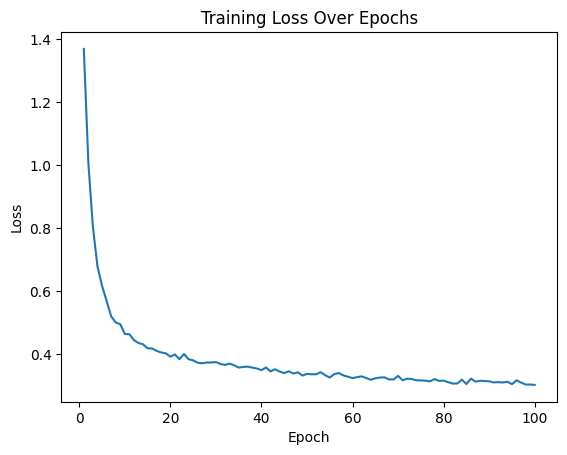

In [30]:
model.train()
aggregated_losses = []

for epoch in range(1, epochs + 1):
    epoch_loss = []
    for batch_idx, (categorical, numerical, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(categorical, numerical)
        loss = loss_function(pred, labels)
        epoch_loss.append(loss.item())
        if epoch % 25 == 1 and batch_idx % 4 == 0:
            print(f'Epoch: {epoch:3} Batch: {batch_idx} Loss: {loss.item()}')
        loss.backward()
        optimizer.step()  
    
    mean_epoch_loss = torch.tensor(epoch_loss).mean()
    aggregated_losses.append(mean_epoch_loss)

    if epoch % 25 == 1:
        print(f'Epoch: {epoch:3} Loss: {mean_epoch_loss:10.8f}')

print(f'Final Epoch: {epoch:3} Loss: {mean_epoch_loss:10.10f}')

# Plotting
plt.plot(range(1, epochs + 1), aggregated_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [31]:
with torch.no_grad():
    model.eval()
    eval = model(categorical_test_data, numerical_test_data)
    loss = loss_function(eval, test_label)
    print(f'Loss: {loss:.8f}')


Loss: 0.25925040


In [32]:
print(eval[:5])
eval = np.argmax(eval.detach().cpu(), axis=1)
print(eval[:5])

tensor([[ 1.5243,  2.8371, -1.8182, -2.5030],
        [ 1.5444,  2.9207, -1.9253, -2.4907],
        [-0.2517, -3.3755,  5.7468, -0.2812],
        [-5.4707, -6.7183, 11.3192,  3.6497],
        [-3.1318, -4.3878,  8.2214,  1.4900]], device='mps:0')
tensor([1, 1, 2, 2, 2])


In [33]:
test_label = test_label.detach().cpu()
print(confusion_matrix(test_label,eval))
print("--------------------------------------------------------------------------------")
print(classification_report(test_label,eval))
print("--------------------------------------------------------------------------------")
print(f"accuracy: {accuracy_score(test_label, eval)*100} %")

[[531  77  13   0]
 [ 14 569   0   0]
 [ 76   1 927   0]
 [  0  15   0  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       621
           1       0.86      0.98      0.91       583
           2       0.99      0.92      0.95      1004
           3       1.00      0.52      0.68        31

    accuracy                           0.91      2239
   macro avg       0.93      0.82      0.85      2239
weighted avg       0.92      0.91      0.91      2239

--------------------------------------------------------------------------------
accuracy: 91.24609200535954 %
